
## Basic settings and parameters

`EBTgymEnv()` class comes preconfigured for quick setting. Basicaly one need to provide at least data file keyword argument to set it up. 

BTgym relies on Backtrader framework for actual environment rendering. Environment customisation can be done either via setting basic set of parameters, inherited from Backtrader computational engine, or passing to env. complete engine  subclass. This example covers basic setting, while  later option gives complete control over backtasting logic and environment becames as flexible as Backtrader itself.
 
Besides, there is another bunch of vital options related to reinforcement learning setting: observation and action space parameters and episode setting.
 
One can eyeball internal environment parameters by looking at nested  `MyEnvironment.params` dictionary consisting of these subdictionaries:
   - `params['dataset']`,  
   - `params['engine']`,
   - `params['strategy']`,
   - `params['other']`.
 
- Look at source files for exact parameters descriptions, since complete doc. reference is yet to come.
##### Here all parameters are left to defaults values:

In [1]:
from btgym import BTgymEnv

# Simpliest trading environment,
# using year-long dataset of one minute bars for EUR/USD currency pair: 

 
MyEnvironment = BTgymEnv(filename='./data/DAT_ASCII_EURUSD_M1_2016.csv',)

# Print parameters and their default values:

for params_name, params_dict in MyEnvironment.params.items():
    print('\nParameters [{}]: '.format(params_name))
    for key, value in params_dict.items():
        print('{} : {}'.format(key,value))
            


Parameters [dataset]: 
filename : ./data/DAT_ASCII_EURUSD_M1_2016.csv
start_weekdays : [0, 1, 2]
start_00 : True
episode_len_days : 1
episode_len_hours : 23
episode_len_minutes : 55
time_gap_days : 0
time_gap_hours : 5
log : <Logger Env (WARNING)>

Parameters [engine]: 
start_cash : 10.0
broker_commission : 0.001
fixed_stake : 10

Parameters [strategy]: 
state_shape : (4, 10)
state_low : 1.03522
state_high : 1.1616
drawdown_call : 90
portfolio_actions : ('hold', 'buy', 'sell', 'close')
skip_frame : 1

Parameters [other]: 
port : 5500
network_address : tcp://127.0.0.1:5500
ctrl_actions : ('_done', '_reset', '_stop', '_getstat', '_render')
verbose : 0


*****
### More control:
##### One can tweak environment setup by passing set of kwargs:

In [2]:
MyEnvironment = BTgymEnv(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                         
                     # Dataset and single random episode related parameters:
                         
                         # We start trading on mondays, thuesdays and wednesdays:
                         start_weekdays=[0, 1, 2],
                         # Want total episode duration to be no more than 1 day 23h 55min:
                         episode_len_days=1,
                         episode_len_hours=23,
                         episode_len_minutes=55,
                         # Want to start every episode at the begiining of the day:
                         start_00=True,
                         
                     # Broker and trade realted:
                         
                         # Set initial capital:
                         start_cash=100,
                         # Set broker commission as 0.2% of operation value:
                         broker_commission=0.002,
                         # We use fixed stake of size 10:
                         fixed_stake=10,
                         # We want stop episode if 30% of initial capital is lost:
                         drawdown_call=30,
                         
                     # RL environment related parameters:
                         
                         # Set obserbation shape. By convention, last dimension 
                         # is time embedding dimensionality;
                         # that's basically means we get sequence of 30 last  
                         # [o,h,l,c] candels as our one-step environment observation.
                         state_shape=(4,30),
                         
                         # Observations min and max. possible values.
                         # Setting these to None forces environment to infer from entire dataset.
                         # Since our obs. space by default consisits of series of prices,
                         # it's quite reasonable:
                         state_low=None,
                         state_high=None,
                         
                     # Other parameters:
                         
                         # Network port to use; note that using multiply environments at once reqires expliciltly
                         # setting differen ports to avoid meesing up. If your jupyter kernel suddenly dies
                         # when running new environment - that's may be because of port conflict,
                         # or 'previous' environment instance (client-side) is still running.
                         # Don't panic, just clear up and restart kernel.
                         port=5555,
                         # Be chatty: settting this to 1 makes environment report what's going on;
                         # 2 is for debugging, dumps out a lot of data:
                         verbose=1,)


[2017-06-29 17:40:26,319] Base Dataset class used.
[2017-06-29 17:40:26,320] Base Cerebro engine used. Base Strategy class used.
[2017-06-29 17:40:27,008] Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2017-06-29 17:40:27,095] Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113610       1.113450       1.113530       0.0
75%         1.124710       1.124780       1.124630       1.124710       0.0
max         1.161440       1.161600       1.160770       1.161450       0.0
[2017-06-29 17:40:27,096] Flushed data.
[2017

*****
### Registering environment:

OpenaAI way of making environment is to register it with cpecific set of parameters under some unique name and instantiate it via calling  `make()` method. This helps for standartization and correct evaluation of results uploaded to Gym board. 
 
##### That's how you do it (same parameters as above):

In [3]:
import gym

# Set single dictionary of parameters:

env_params = dict(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                  start_weekdays=[0, 1, 2],
                  episode_len_days=1,
                  episode_len_hours=23,
                  episode_len_minutes=55,
                  start_00=True,
                  start_cash=100,
                  broker_commission=0.002,
                  fixed_stake=10,
                  drawdown_call=30,
                  state_shape=(4,30),
                  state_low=None,
                  state_high=None,
                  port=5555,
                  verbose=1,)

# Register with unique name (watch out for OpenAI namesetting conventions):

gym.envs.register(id='backtrader-v46',
                  entry_point='btgym:BTgymEnv',
                  kwargs=env_params)

# Make environment:
                  
MyEnvironment = gym.make('backtrader-v46')


[2017-06-29 17:40:39,946] Making new env: backtrader-v46
[2017-06-29 17:40:39,948] Base Dataset class used.
[2017-06-29 17:40:39,950] Base Cerebro engine used. Base Strategy class used.
[2017-06-29 17:40:40,644] Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2017-06-29 17:40:40,732] Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113610       1.113450       1.113530       0.0
75%         1.124710       1.124780       1.124630       1.124710       0.0
max         1.161440       1.161600       1.160770       1.16145

*****
### Running agent:

Just for giving sense of env. operation flow, our agent will be just mindless random picker; it performs no actual training. Run it for several episodes to see how fast all the money get lost.
- we'll plot states observationas every 500th and final step, episode summary and rendering;
- set verbosity=0 to turn of excesive messaging.

In [4]:
import itertools
import random

# Will need those
# to display rendered images inline:
import IPython.display as Display
import PIL.Image as Image


# Some utility functions:

def to_string(dictionary):
    """Convert dictionary to block of text."""
    text = ''
    for k, v in dictionary.items():
        if type(v) in [float]:
            v = '{:.4f}'.format(v)
        text += '{}: {}\n'.format(k, v)
    return(text)

def show_rendered_image(rgb_array):
    """
    Convert numpy array to RGB image using PILLOW and
    show it inline using IPykernel.
    This method doesn't requires matplotlib to be loaded.
    """
    Display.display(Image.fromarray(rgb_array))

# Number  episodes to run:
num_episodes = 2

# Render state every:
state_render=500

 Pay attention to log output: when called for first time, `env.reset()` will start the server and calls for episode;  server than samples episode data, checks it for consistency, starts backtesting and returns initial state observation.

[2017-06-29 17:52:03,398] No running server found, starting...
[2017-06-29 17:52:03,478] Server PID: 22585
[2017-06-29 17:52:04,249] Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2017-06-29 17:52:04,475] Server started, pinging tcp://127.0.0.1:5555 ...
[2017-06-29 17:52:04,478] Server seems ready with response: <{'ctrl': 'send control keys: <_reset>, <_getstat>, <_render>, <_stop>.'}>
[2017-06-29 17:52:04,479] Starting episode.
[2017-06-29 17:52:04,483] Maximum episode time duration set to: 1 day, 23:55:00.
[2017-06-29 17:52:04,484] Respective number of steps: 2875.
[2017-06-29 17:52:04,485] Maximum allowed data time gap set to: 5:00:00.

[2017-06-29 17:52:04,488] Episode start: 2016-11-29 02:09:00, weekday: 1.
[2017-06-29 17:52:04,489] Start time adjusted to <00:00>
[2017-06-29 17:52:04,509] Episode duration: 1 day, 23:55:00.
[2017-06-29 17:52:04,510] Total episode time gap: 0:00:00.
[2017-06-29 17:52:04,512] Sample accepted.
[2017-06-29 17:52:04,531] Da


EPISODE [1]:


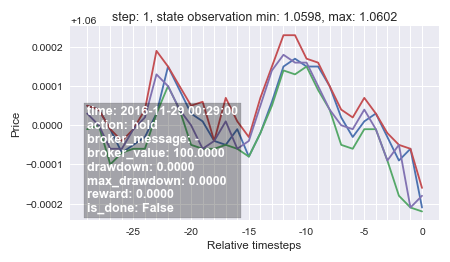

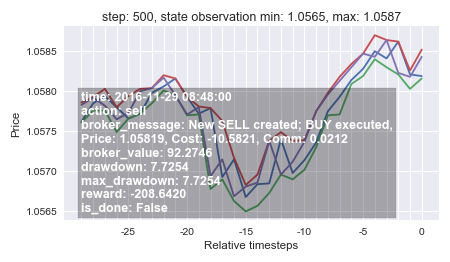

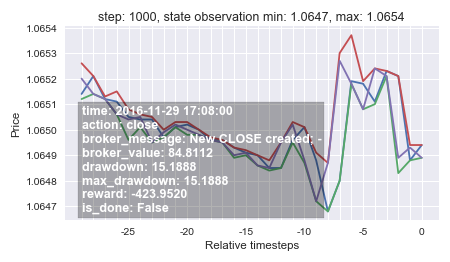

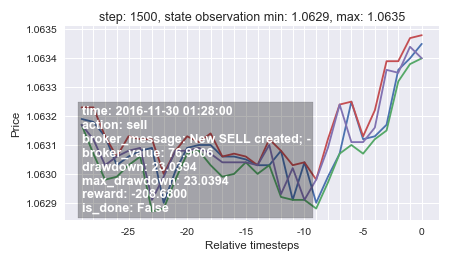

[2017-06-29 17:52:13,083] Episode elapsed time: 0:00:08.548234.


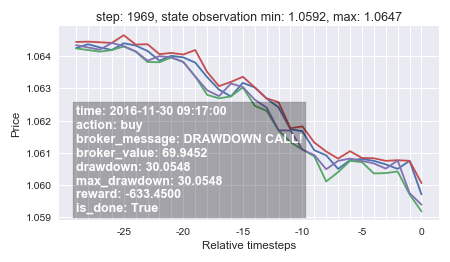

SUMMARY:
episode: 1
runtime: 0:00:08.548234

INFO [last observation]:
step: 1969
time: 2016-11-30 09:17:00
action: buy
broker_message: DRAWDOWN CALL!
broker_value: 69.9452
drawdown: 30.0548
max_drawdown: 30.0548

BACKTRADER SUMMARY PLOT:


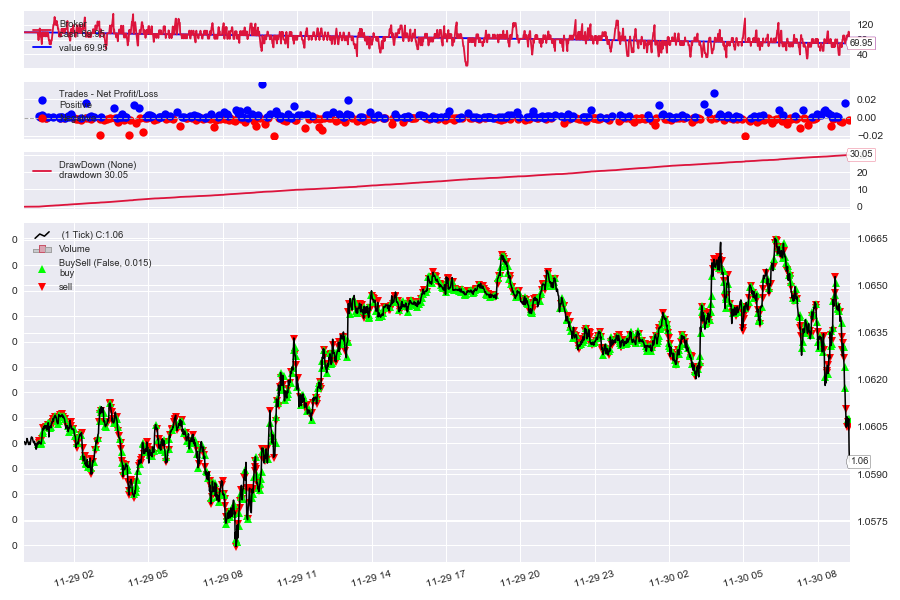

[2017-06-29 17:52:13,874] Starting episode.
[2017-06-29 17:52:13,876] Maximum episode time duration set to: 1 day, 23:55:00.
[2017-06-29 17:52:13,878] Respective number of steps: 2875.
[2017-06-29 17:52:13,879] Maximum allowed data time gap set to: 5:00:00.

[2017-06-29 17:52:13,881] Episode start: 2016-10-12 06:28:00, weekday: 2.
[2017-06-29 17:52:13,883] Start time adjusted to <00:00>
[2017-06-29 17:52:13,886] Episode duration: 1 day, 23:57:00.
[2017-06-29 17:52:13,887] Total episode time gap: 0:02:00.
[2017-06-29 17:52:13,889] Sample accepted.
[2017-06-29 17:52:13,902] Data summary:
              open         high          low        close  volume
count  2875.000000  2875.000000  2875.000000  2875.000000  2875.0
mean      1.102859     1.102941     1.102776     1.102857     0.0
std       0.001623     0.001617     0.001630     0.001623     0.0
min       1.098660     1.098700     1.098520     1.098630     0.0
25%       1.101560     1.101640     1.101480     1.101560     0.0
50%       1


EPISODE [2]:


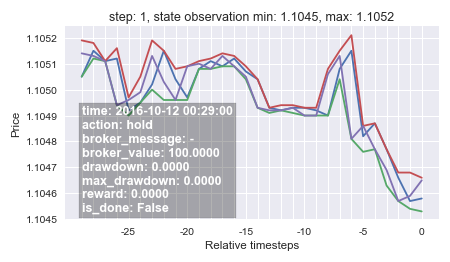

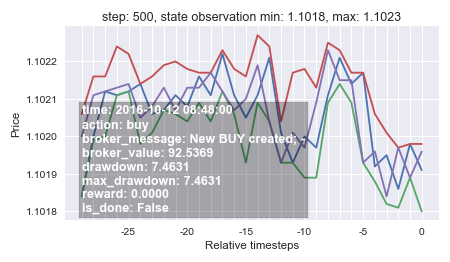

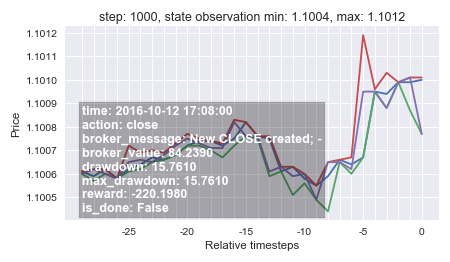

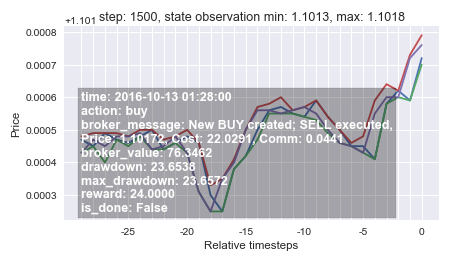

[2017-06-29 17:52:21,678] Episode elapsed time: 0:00:07.772739.


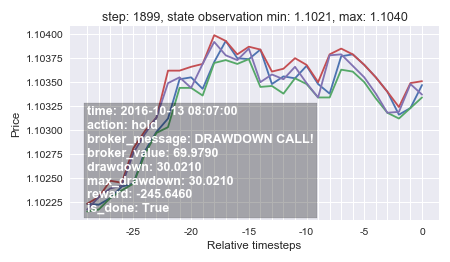

SUMMARY:
episode: 2
runtime: 0:00:07.772739

INFO [last observation]:
step: 1899
time: 2016-10-13 08:07:00
action: hold
broker_message: DRAWDOWN CALL!
broker_value: 69.9790
drawdown: 30.0210
max_drawdown: 30.0210

BACKTRADER SUMMARY PLOT:


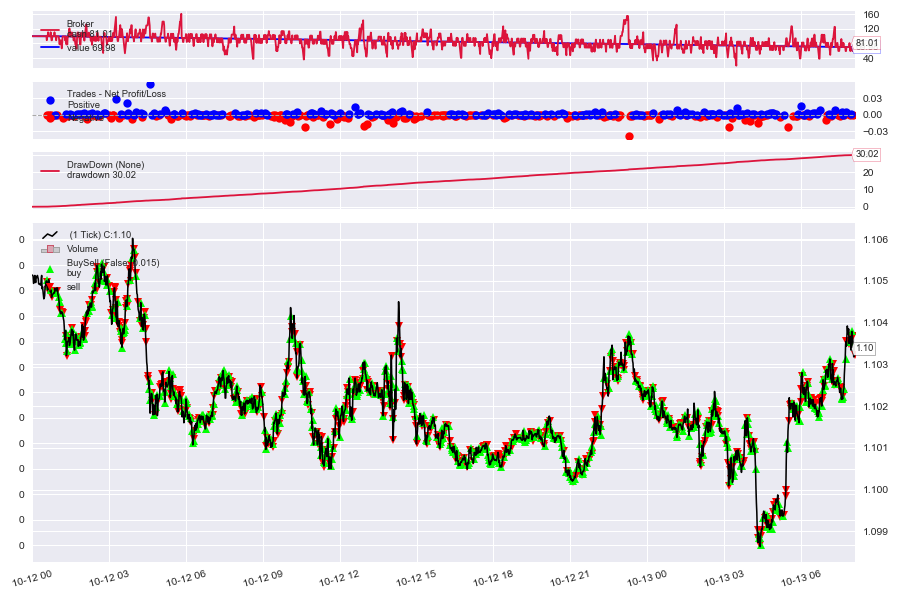

[2017-06-29 17:52:22,394] Server is exiting.
[2017-06-29 17:52:22,397] Server is exiting. Exit code: None


In [8]:
# Run it:
for episode in range(num_episodes):
    
    # Calling reset() before every episode.

    init_state = MyEnvironment.reset()
    
    print('\nEPISODE [{}]:'.format(episode + 1))
    
    # Render and show first step:
    show_rendered_image(MyEnvironment.render('human'))
    
    # Repeat until episode end:
    for _ in itertools.count(): 
        
        #Choose random action:
        rnd_action = int((MyEnvironment.action_space.n)*random.random())
        
        # Make a step in the environment:
        obs, reward, done, info = MyEnvironment.step(rnd_action)
        
        # Show state every 500th step
        # and when episode is finished:
        if info[-1]['step'] % state_render == 0 or done:
            show_rendered_image(MyEnvironment.render('human'))
                
        if done: break
            
    # Print episode statistic (quite modest for now since we didn't added any observers etc.)
    print('SUMMARY:\n{}\nINFO [last observation]:\n{}'.
        format(to_string(MyEnvironment.get_stat()), to_string(info[-1])))
    # Render and show episode statisic:
    print('BACKTRADER SUMMARY PLOT:')
    show_rendered_image(MyEnvironment.render('episode'))

# Clean up:
MyEnvironment.close()